In [1]:
#Import liabraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.metrics import r2_score
from sklearn.metrics import SCORERS

In [2]:
#Open The Data File to a Data Frame and open The Data Set Description file

In [3]:
#Data set
f = open('data/slump_test.data',"r")
data = []
for x in f:
    data.append(x)
df = pd.DataFrame(data)
df = df[0].str.split(',', expand=True)
df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: x.rstrip())
df.columns = df.iloc[0]
df = df.rename(columns = {'Compressive Strength (28-day)(Mpa)': 'CS'})
df = df.iloc[1:, 1:]
df = df.apply(pd.to_numeric) #convert to numeric format
df = df.drop_duplicates(keep='first') #delete potential duplicates

#Description of the data set
with open('data/slump_test.names', 'r') as myfile:
    description = myfile.read().replace('\n', ' ').replace('\r', '')

### Introduction to the problem

The compressive strength of concrete is the most common perfomance measure used by engineer in designing buildings and other structures.  

**What is the Compressive Strength of Concrete?**

The Compressive Strength of Concrete is performed to check the workability of freshly made concrete. It is measured by breaking cyclindrical concreate specimens in a compression-testing machine:  


<center>$Compressive Strength = \frac{Failure Load}{Cross-Sectional Area}$</center>  

This measure is usually reported in megapascals (MPa) and usually strength requirement for concrete are at an age of 28 days. Compressive Strength of Concrete requirement can vary a lot for residential concreates and for commertial structures. Very high values are needed for specific applications.

Compressive strength result are primarily used to determine that the concreate mixture as delivered meets the requirement. Strength results can be used for quality control, acceptance of concreate, or even scheduling construction operations.

<img src="pics/test.jpg" width="300" height="300">


**Why we might want to investigate this field?**  

High performance is the most important expectation from concrete which is commonly used in today’s construction technology. 

So we face the problem of optimization of the materials used to form the concrete in order to decrease the costs of construction and at the same time meet the workability requirement of concrete. 


### EDA

1. Conduct an exploratory data analysis (EDA) on the ten variables included in the dataset.   
Generatecsome visual representations to illustrate the characteristics of the data.

In [4]:
df.head() #lets' look at the sample of data

0  Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  SLUMP(cm)  \
1   273.0   82.0    105.0  210.0   9.0         904.0       680.0       23.0   
2   163.0  149.0    191.0  180.0  12.0         843.0       746.0        0.0   
3   162.0  148.0    191.0  179.0  16.0         840.0       743.0        1.0   
4   162.0  148.0    190.0  179.0  19.0         838.0       741.0        3.0   
5   154.0  112.0    144.0  220.0  10.0         923.0       658.0       20.0   

0  FLOW(cm)     CS  
1      62.0  34.99  
2      20.0  41.14  
3      20.0  41.81  
4      21.5  42.08  
5      64.0  26.82

In [5]:
print('The shape of the data set is: {}'.format(df.shape))
df.isnull().sum() != 0 #check if nans exist

The shape of the data set is: (103, 10)


0
Cement          False
Slag            False
Fly ash         False
Water           False
SP              False
Coarse Aggr.    False
Fine Aggr.      False
SLUMP(cm)       False
FLOW(cm)        False
CS              False
dtype: bool

In [6]:
# Descriptive statistics for each column
df.describe()

0          Cement        Slag     Fly ash       Water          SP  \
count  103.000000  103.000000  103.000000  103.000000  103.000000   
mean   229.894175   77.973786  149.014563  197.167961    8.539806   
std     78.877230   60.461363   85.418080   20.208158    2.807530   
min    137.000000    0.000000    0.000000  160.000000    4.400000   
25%    152.000000    0.050000  115.500000  180.000000    6.000000   
50%    248.000000  100.000000  164.000000  196.000000    8.000000   
75%    303.900000  125.000000  235.950000  209.500000   10.000000   
max    374.000000  193.000000  260.000000  240.000000   19.000000   

0      Coarse Aggr.  Fine Aggr.   SLUMP(cm)   FLOW(cm)          CS  
count    103.000000  103.000000  103.000000  103.00000  103.000000  
mean     883.978641  739.604854   18.048544   49.61068   36.039417  
std       88.391393   63.342117    8.750844   17.56861    7.838232  
min      708.000000  640.600000    0.000000   20.00000   17.190000  
25%      819.500000  684.500000   14.500000   38.50000   30.900000  
50%      879.000000  742.700000   21.500000   54.00000   35.520000  
75%      952.800000  788.000000   24.000000   63.75000   41.205000  
max     1049.900000  902.000000   29.000000   78.00000   58.530000

Text(0, 0.5, 'Frequancy')

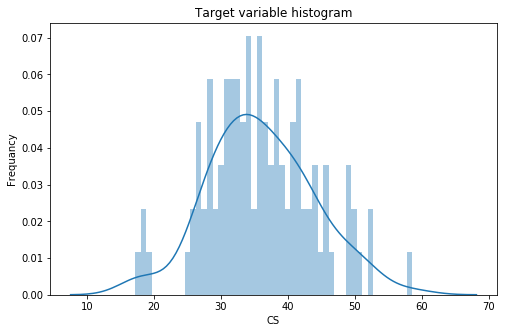

In [7]:
plt.figure(figsize=(8, 5))
sns.distplot(df['CS'], bins=50, hist_kws={'alpha': 0.4});
plt.title('Target variable histogram')
plt.ylabel('Frequancy')

<center> Visual characteristics of the data </center>

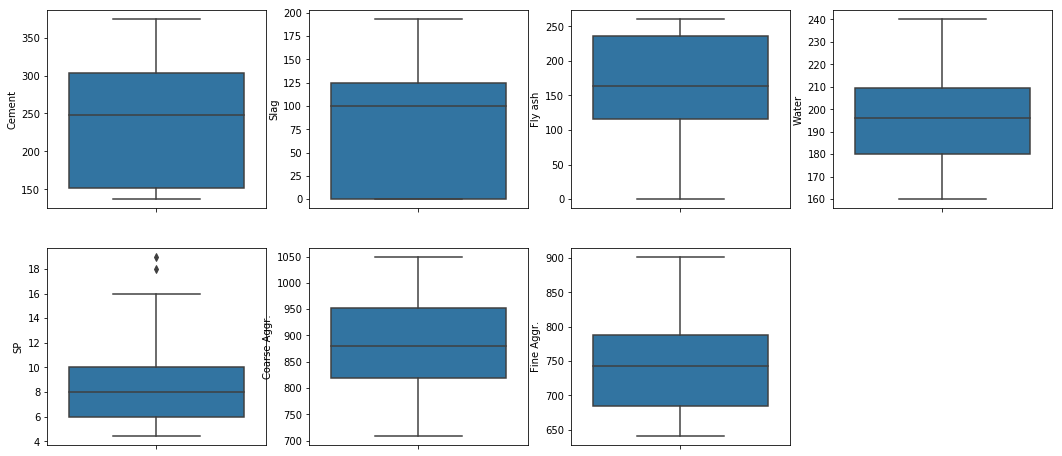

In [8]:
features_to_analyse = df.columns[:7]
current_palette = sns.color_palette("Blues")

fig, axes = plt.subplots(round(len(features_to_analyse)/4), 4, figsize = (18, 8))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse):
        sns.boxplot(x=features_to_analyse[i], data = df, ax = ax, orient = 'v')
fig.delaxes(ax = axes[1,3])

There is no a lot ouliers in the data set, we can only observe 2 points of outliers in SP (superplasticizer).

Moreover tree-based model not sencitive to ouliers.

**Colinearity**. Colinearity is the state where two variables are highly correlated and contain similiar information about the variance within a given dataset. To detect colinearity among variables, simply create a correlation matrix and find variables with large absolute values.

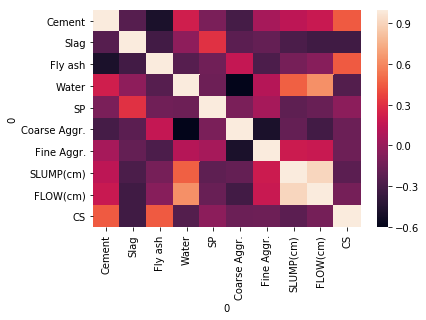

In [9]:
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

We can observe high collinearity between some variables like:
* Cement and Fly ash
* Water and Coarse Aggregation

So we probably will not include those variables in the model at the same time, but we can inlude only one variable from those sets with the highest correlation with target variable.

In [10]:
df['binned_CS'] = pd.cut(df['CS'], bins=10, labels=False).values  #binned target

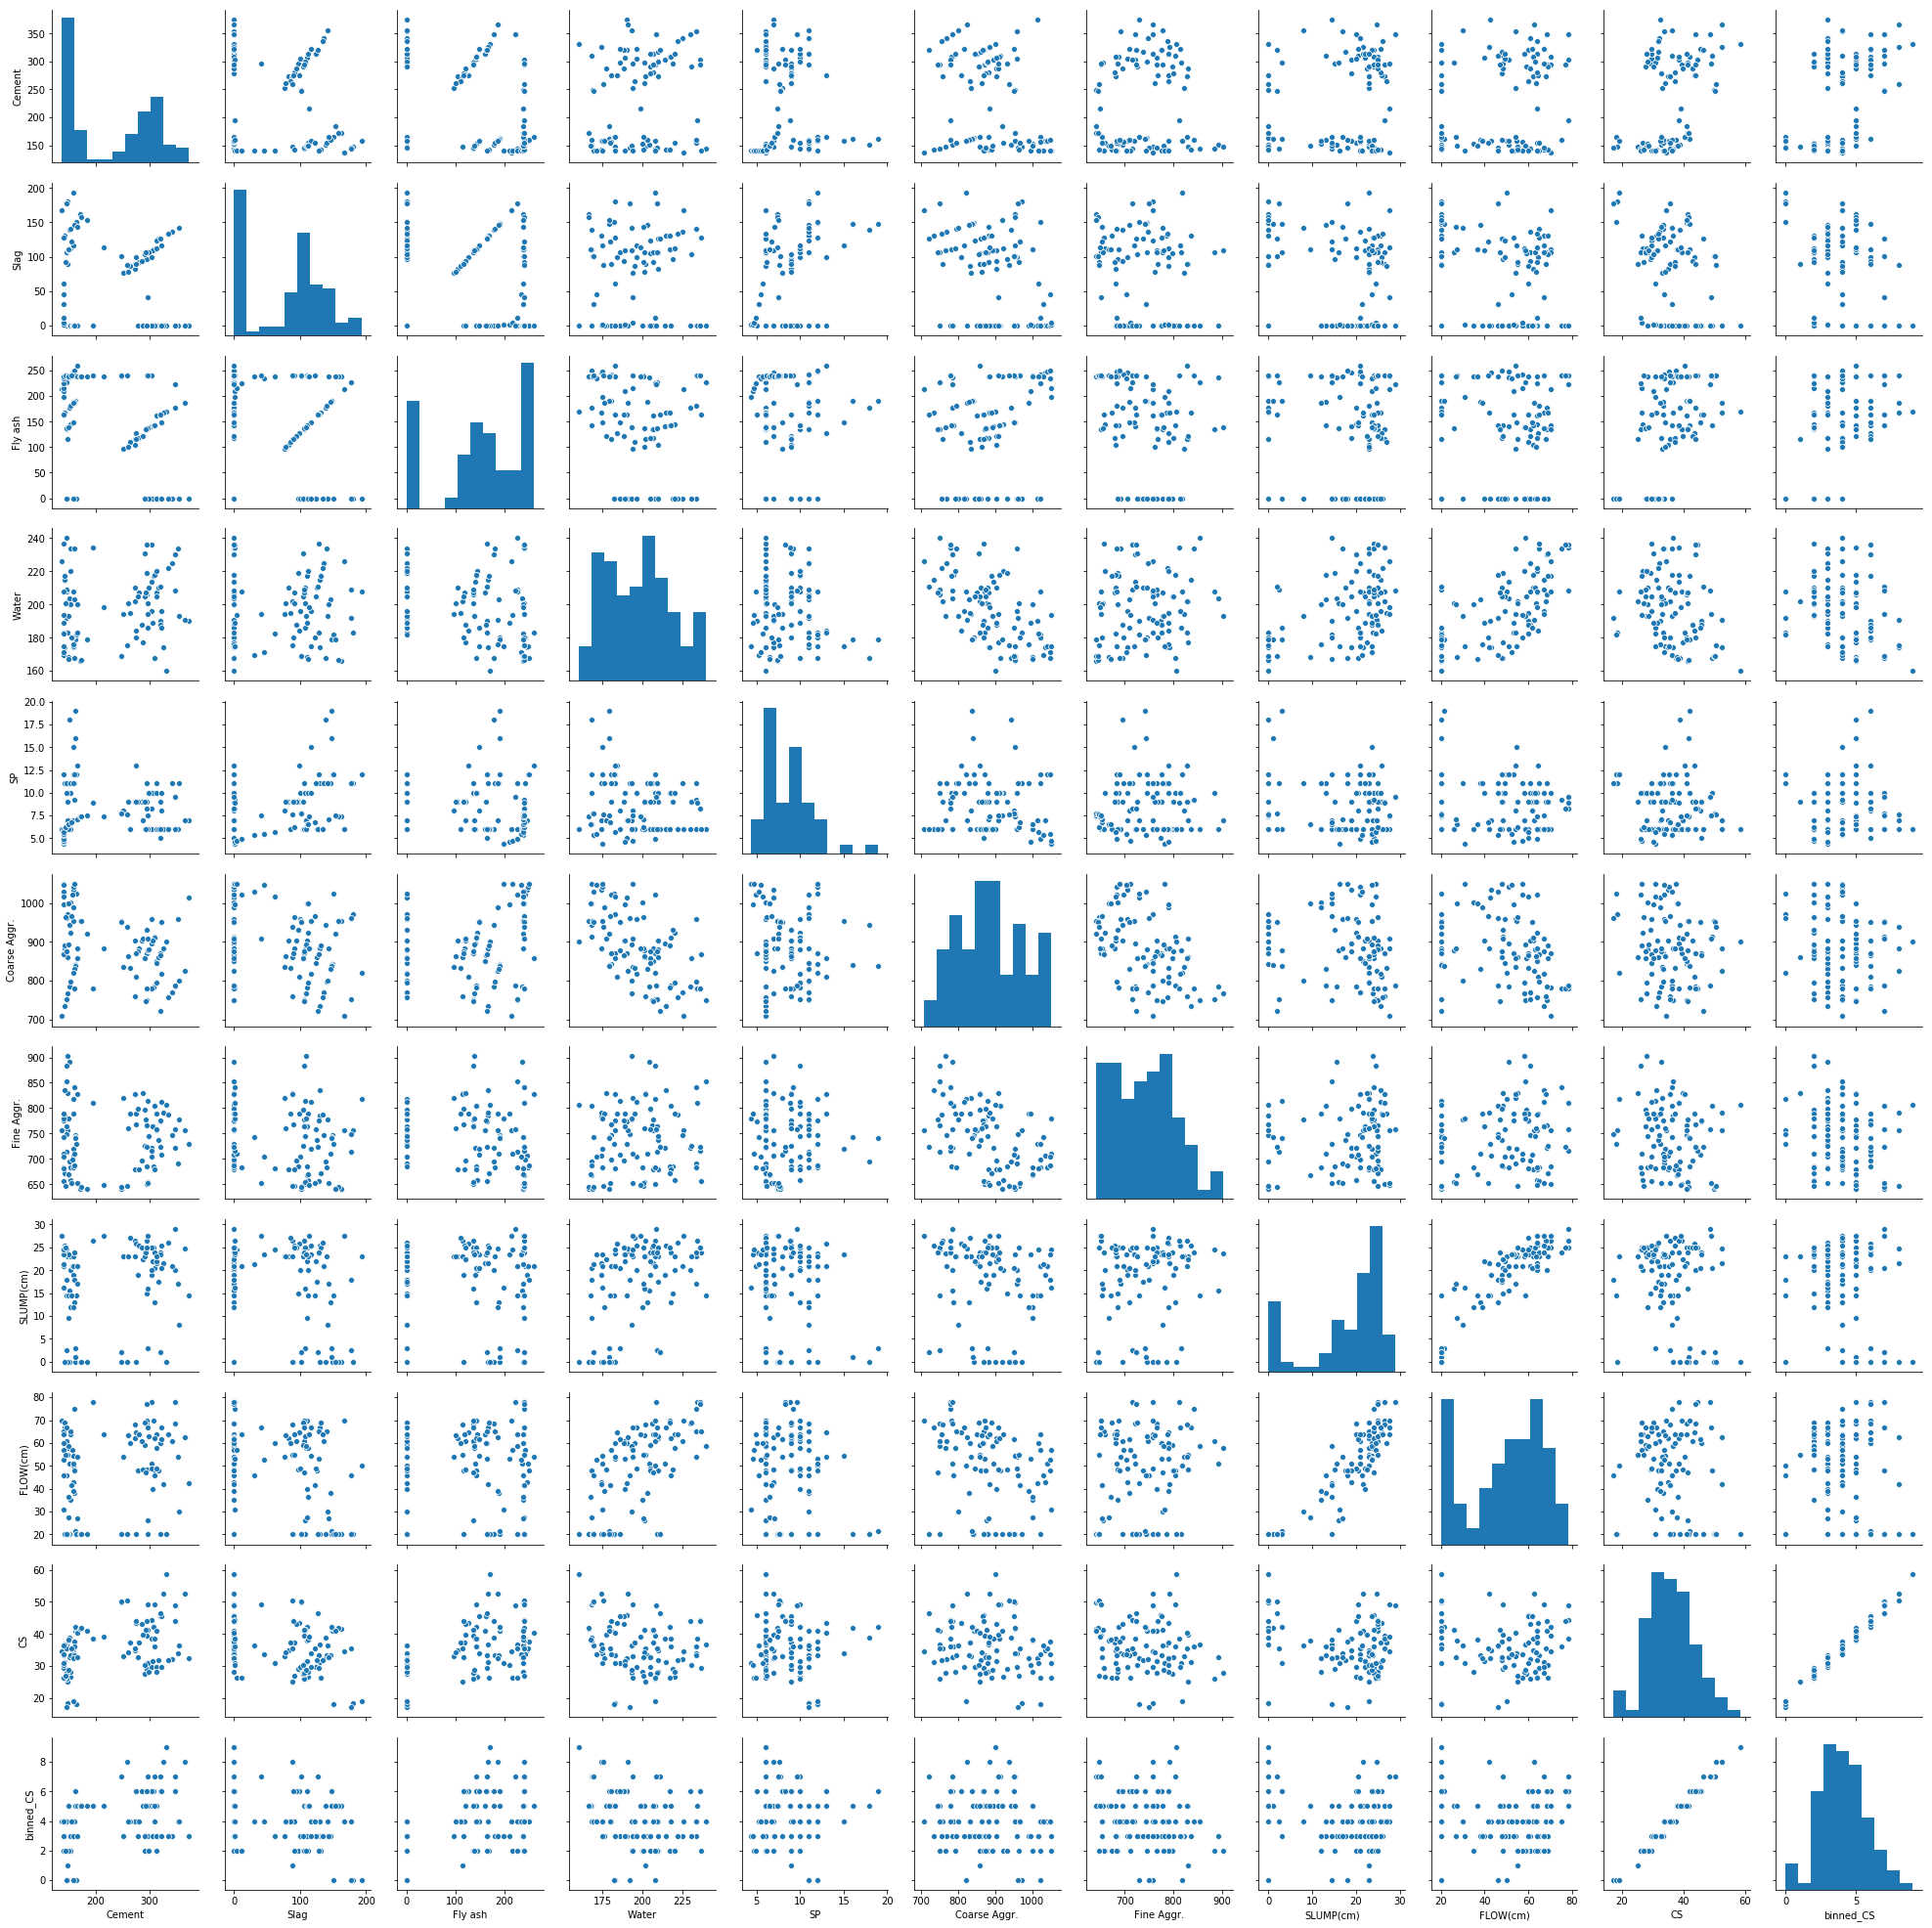

In [11]:
sns.pairplot(df)

2. Generate a visual representation that illustrates the correlation between 28-day compressive
strength (CS) and the seven input measurement features. In order to make this easier to interpret,
stratify CS into bins in order to make your visual representations easier to interpret.

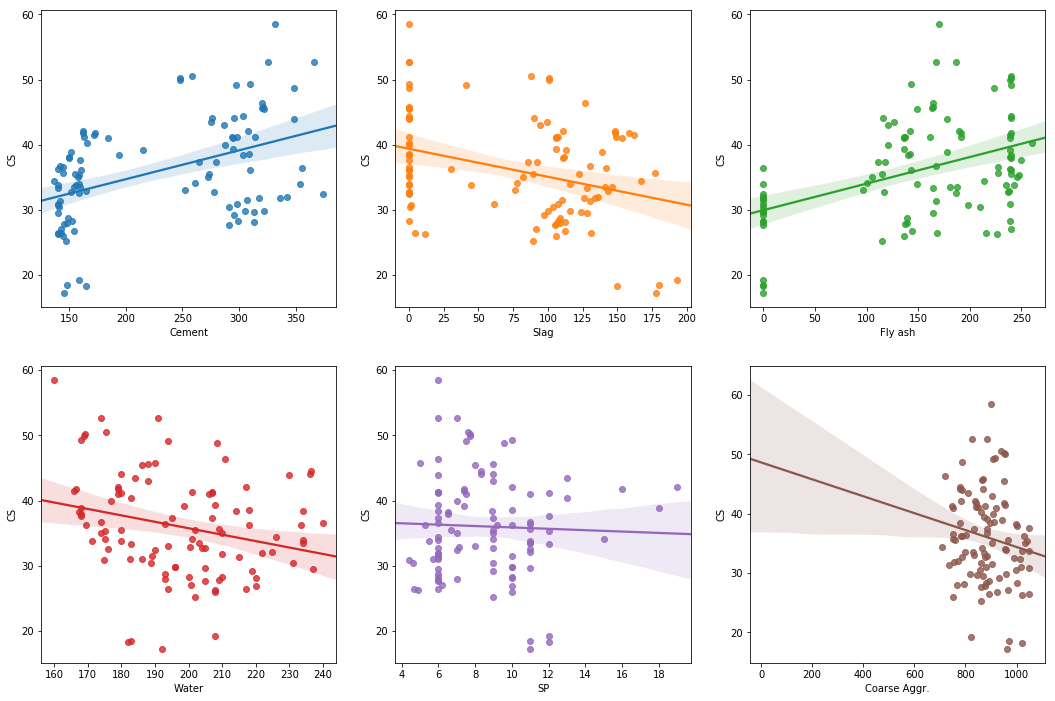

In [12]:
features_to_analyse = df.columns[:7]
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],y='CS', data = df, ax=ax)

Let's look at the numerical correlation estimations

In [13]:
df[features_to_analyse].apply(lambda x: x.corr(df['CS']))

0
Cement          0.445725
Slag           -0.331588
Fly ash         0.444393
Water          -0.254235
SP             -0.037871
Coarse Aggr.   -0.160684
Fine Aggr.     -0.154484
dtype: float64

**Conclusion:** Non collinear features most correlated with the target variable are:  
* Cement 
* Flu ash

### Modeling

3. Create a single decision tree model that can reasonably predict CS using only the top two most
important input measurement features, as identified in the previous stage. Generate a visual
representation of your decision tree model and include the test set root mean square error (RMSE).

<center> Decision tree model </center>

In [14]:
X_train, X_test, y_train, y_test = train_test_split( 
          df[['Fly ash', 'Cement']], df['CS'], test_size = 0.1, random_state = 100) #train test split 

In [15]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (92, 2)
Training Labels Shape: (92,)
Testing Features Shape: (11, 2)
Testing Labels Shape: (11,)


Hyperparameter Tuning. Due to small data set the most important hyperparameter to be tunes is **max depth**, others (min samples split, min samples leaf) will be stayed with defaul values 

* Max depth

In [16]:
#Cross validation
cross_val = []
depths = range(1,10)

test = []
for i in depths:

    dt = tree.DecisionTreeRegressor(max_depth=i, min_samples_split=3, min_samples_leaf=2)
    dt.fit(X_train, y_train)
    # Perform 3-fold cross validation 
    scores = cross_val_score(estimator=dt, X=X_train, y=y_train, cv=5, n_jobs=4, scoring='r2')
    print(scores)
    cross_val.append(scores.mean())
    predictions = dt.predict(X_test)
    test.append(r2_score(y_test, predictions))

[ 0.33146145 -0.27230508 -0.49528517  0.28671056  0.30114262]
[0.7026002  0.44186853 0.10205212 0.51092009 0.42717996]
[0.7305786  0.59093442 0.66256659 0.38309811 0.54815206]
[0.64216122 0.47027927 0.72853649 0.5648012  0.57857397]
[0.73000732 0.3623814  0.75753735 0.50443435 0.48420082]
[0.73954411 0.22036159 0.71165326 0.42885059 0.43440878]
[0.80327194 0.23262503 0.68282838 0.44990695 0.42019925]
[0.73683163 0.23227681 0.68282838 0.45485157 0.4212694 ]
[0.74124251 0.23227681 0.68282838 0.59863707 0.4212694 ]


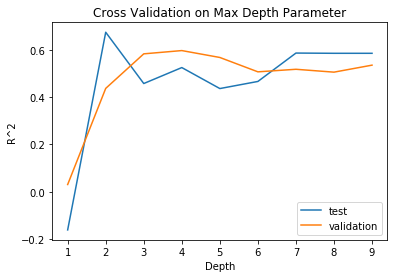

In [17]:
plt.plot(range(1,10),test, label='test')
plt.plot(range(1,10),cross_val, label = 'validation')
plt.title('Cross Validation on Max Depth Parameter')
plt.xlabel('Depth')
plt.ylabel('R^2')
plt.legend()

The best depth to be set in the model - 2

In [18]:
def rmse(y_pred, y): #rmse formula
    return round(np.sqrt((y_pred - y)**2).mean(), 2)

In [19]:
dt = tree.DecisionTreeRegressor(max_depth=2, min_samples_split=2, min_samples_leaf=2)
dt = dt.fit(X_train, y_train)
predictions = dt.predict(X_test)
print('RMSE on the test data: {}'.format(rmse(predictions, y_test)))

RMSE on the test data: 3.4


<center> Visialization of decision tree model </center>

In [20]:
export_graphviz(dt, out_file='pics/tree.dot', 
                feature_names = X_train.columns,
                class_names = 'CS',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

!dot -Tpng tree.dot -o tree.png -Gdpi=2500

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'pics/tree.png')

Error: dot: can't open tree.dot


4. Next, create a random forest model that can reasonably predict CS using any/all of the input
measurement features. Generate a visual representation of your random forest model and include the
test set root mean square error (RMSE).

<center> Random forest model </center>

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

We will tune hyperparameters with GridSearch here

In [21]:
df.columns

Index(['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.',
       'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)', 'CS', 'binned_CS'],
      dtype='object', name=0)

In [22]:
X_train, X_test, y_train, y_test = train_test_split( 
          df[['Fly ash', 'Cement', 'Slag', 'Water', 'SP', 'Coarse Aggr.', 'Fine Aggr.']], df['CS'], test_size = 0.1, random_state = 100) #train test split 

In [23]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint

In [24]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [25]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   37.1s finished
/Users/natali/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [26]:
print("R^2 Score of Fandom Forest with tuned parameters with GridSearch: {}".format(round(r2_score(y_test, rf_random.predict(X_test)), 2)))
print("RMSE Score of Fandom Forest with tuned parameters with GridSearch: {}".format(round(rmse(y_test, rf_random.predict(X_test)), 2)))

R^2 Score of Fandom Forest with tuned parameters with GridSearch: 0.84
RMSE Score of Fandom Forest with tuned parameters with GridSearch: 2.42


### Further analysis

5. Think through additional analyses you might perform on the dataset if you were given more time (no additional analyses required).

**a**. What alternative methods might you use to predict CS?

If I had more data I would use also try folowing approaches (I have some papers which used these model for the same problem, for example [https://www.hindawi.com/journals/amse/2016/7648467/]):
* Least Squares Support Vector Regression
* Artificial neural networks

**b**. What additional data, not included in the dataset, might help better predict CS?

Besides the constituent of materials, the Compressive Strength of Concrete is also affected by:
* environmental exposure
* extreme working conditions

Furthermore, other properties of concrete, such as elastic modulus, water tightness or impermeability, and resistance to weathering agents including aggressive waters

**c**. Based on the EDA you completed in the first step, what additional analyses might you complete
based on the data structure?

I mightalso perform a multicollinearity analysis based on the VIF values.

**d.** What applications might your analysis lead to? In plain English, describe what business value
these models could provide to a prospective client.

Predicting concrete strength can be helpful in assessing the deterioration of concrete structures and increasing their safety (quality control, acceptance of concrete, even scheduling construction operations). 
Business values
* Optimization of the materials used to form the concrete in order to decrease the costs of construction and at the same time meet the workability requirement of concrete
* Increasing the safety
* Preventing the expenses in case of emergency 